In [139]:
### load modules

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'


from qa_utils import *

# reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
# Merian data repo
root = '/projects/MERIAN/repo'
butler = dafButler.Butler(root)

In [141]:
list_tract_ids = [9813] # example tracts

dataset = {} # dict to keep key statistics for each tract
for tract_id in list_tract_ids:
    
    dataset[tract_id] = {}
    
    #---------------- 
    # Loop over patches to check the num of  visits for each tract
    #---------------- 
    visits_ids = []
    for i in range(6):
        print('Patch', i )
        for bandname in ['N708','N540']:
            img_id = {'tract': tract_id, 'patch': i, 'band': bandname}
            try:
                coadd_ = butler.get('deepCoadd_calexp',
                        dataId=img_id,
                        instrument='DECam',skymap='hsc_rings_v1',
                        collections='DECam/runs/merian/dr1_wide')
            except LookupError:
                print('No data for ', img_id)
                continue
            visits = coadd_.getInfo().getCoaddInputs().visits['id']
            visits_ids += list(visits)
    visits_ids = np.unique(visits_ids)
    print('visit id list: ', visits_ids)


Patch 0


Reading from location file:///projects/MERIAN/repo/DECam/runs/merian/dr1_wide/20221017T142820Z/deepCoadd_calexp/9813/0/N540/deepCoadd_calexp_9813_0_N540_hsc_rings_v1_DECam_runs_merian_dr1_wide_20221017T142820Z.fits  with formatter lsst.obs.base.formatters.fitsExposure.FitsExposureFormatter: Took 3.4836 seconds


KeyboardInterrupt: 

In [ ]:
tract = 8765
collection = 'DECam/runs/merian/dr1_wide/20221006T145423Z'
skymap = 'hsc_rings_v1'

cat_coadd = butler.get( 'objectTable_tract', tract=tract, instrument='DECam',
                        skymap=skymap, collections=collection)
skyobj_cat = cat_coadd[cat_coadd.merge_peak_sky==True]


**Sky Object Check**


In [ ]:
# set fname = None so that show the plot in the notebook
median, std, mid_patch, std_patch = plot_coadd2d_oneTract(skyobj_cat,tract = tract,colname = 'N708_gaapOptimalFlux_Merian', fname=None)

[]


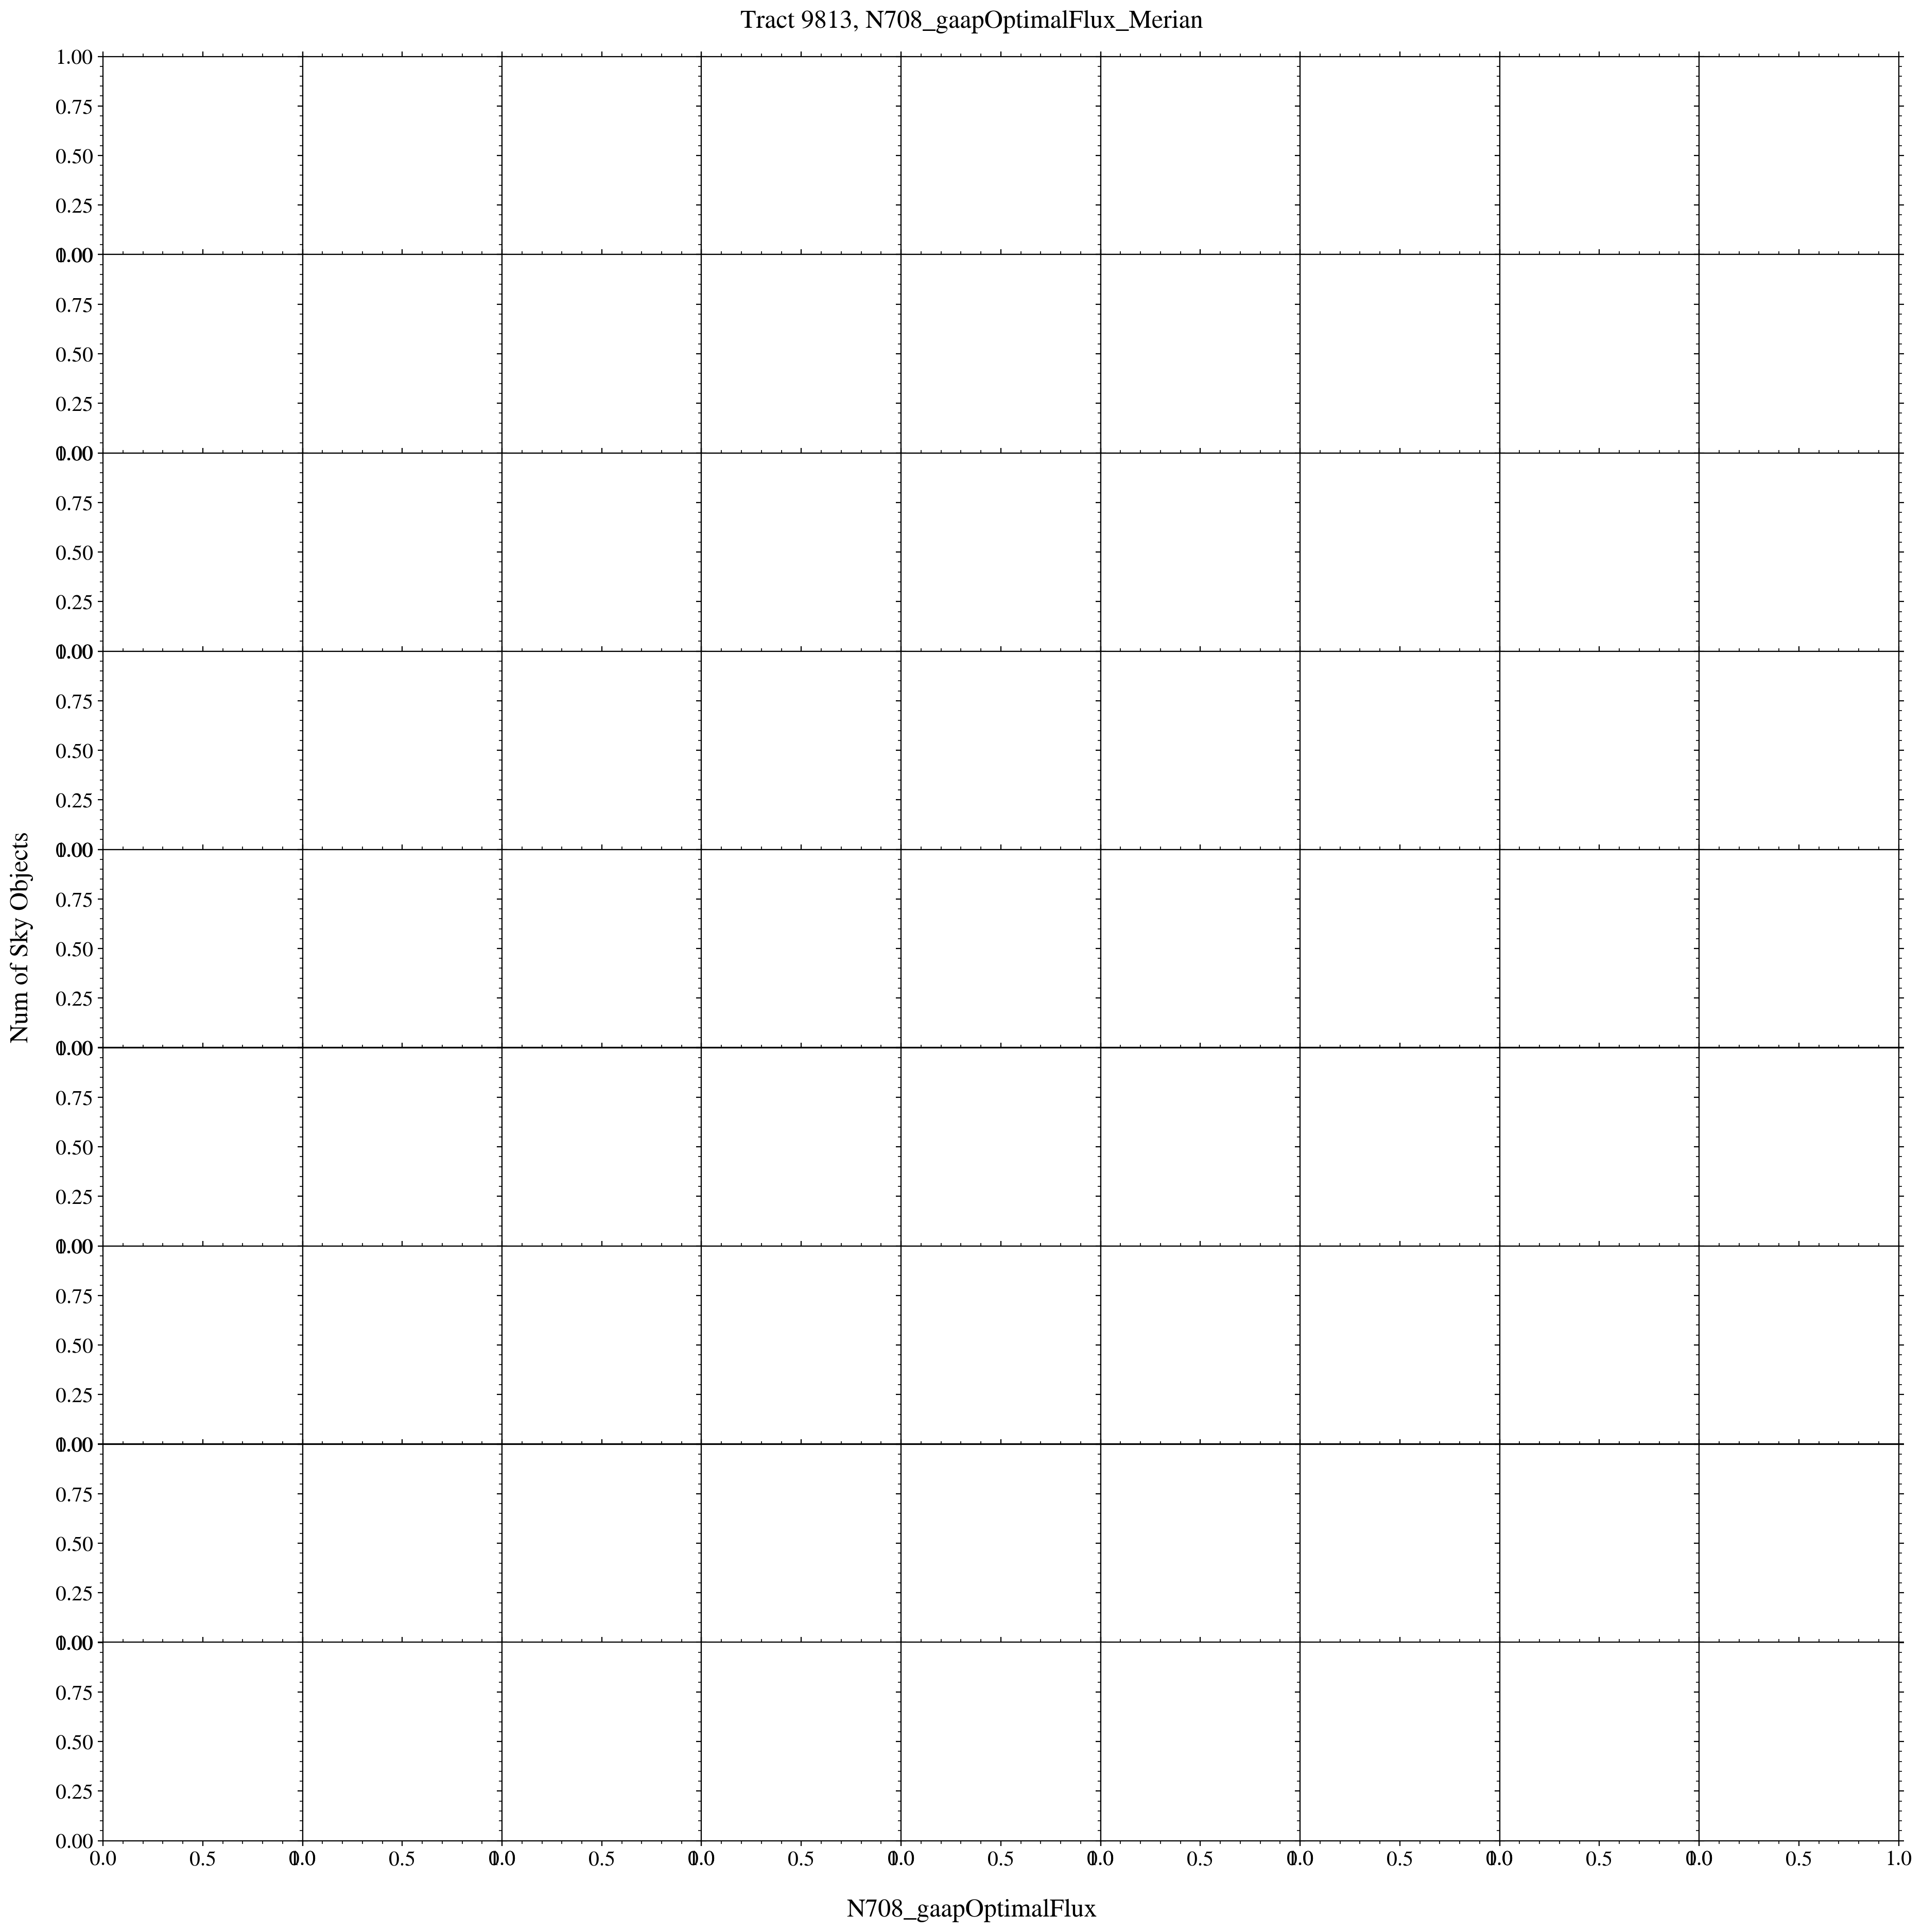

In [39]:
patch_list = np.unique(skyobj_cat['patch_Merian'].data)
print(patch_list)


colname = 'N708_gaapOptimalFlux_Merian'

fig, axes = plt.subplots(9,9, figsize=(9*2.5,9*2.5), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)


xlim = [-400,400]

# ---------------- Loop over patches -----------#
for patch_id in patch_list:

        # load the skyobj catalog for this patch
        patch_cat = skyobj_cat[skyobj_cat['patch_Merian']==patch_id]
        patch_flux_raw = patch_cat[colname]
        mask, patch_flux = sigmaclip(patch_flux_raw)
        Neff = len(patch_flux)
        
        # calculate the median and std of the flux
        mid_flux = np.nanmedian(patch_flux)
        std_flux = np.sqrt(np.nanmean((patch_flux-mid_flux)**2))
        max_flux = np.nanmax(patch_flux)
        min_flux = np.nanmin(patch_flux)
        
        # plot the histogram
        nrow = patch_id//9
        ncol = patch_id%9


        ax = axes[8-nrow][ncol]
        ax.hist(patch_flux,bins='auto',facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.8,alpha=0.5)
        ax.axvline(mid_flux,ls='-',color='tab:blue',lw=1)
        ax.axvline(mid_flux - std_flux,ls='--',color='tab:blue',lw=1)
        ax.axvline(mid_flux + std_flux,ls='--',color='tab:blue',lw=1)
        ax.text(0.95,0.95,s='$\mu$=%.2f\n$\sigma$=%.2f\n\nmax=%.2f\nmin=%.2f'%(mid_flux,std_flux,max_flux,min_flux),transform=ax.transAxes,va='top', ha='right', fontsize=12)
        ax.text(0.05, 0.95, s='%d-(%d,%d)'%(patch_id, nrow, ncol), transform=ax.transAxes,va='top', ha='left', fontsize=15, color='tab:red')

        ax.set_xlim(xlim[0], xlim[-1])

_ = fig.suptitle('Tract %d, %s'%(tract,colname), y=0.9)
_ = fig.supxlabel('N708_gaapOptimalFlux', x=0.5, y=0.075)
_ = fig.supylabel('Num of Sky Objects', x=0.085, y=0.5)

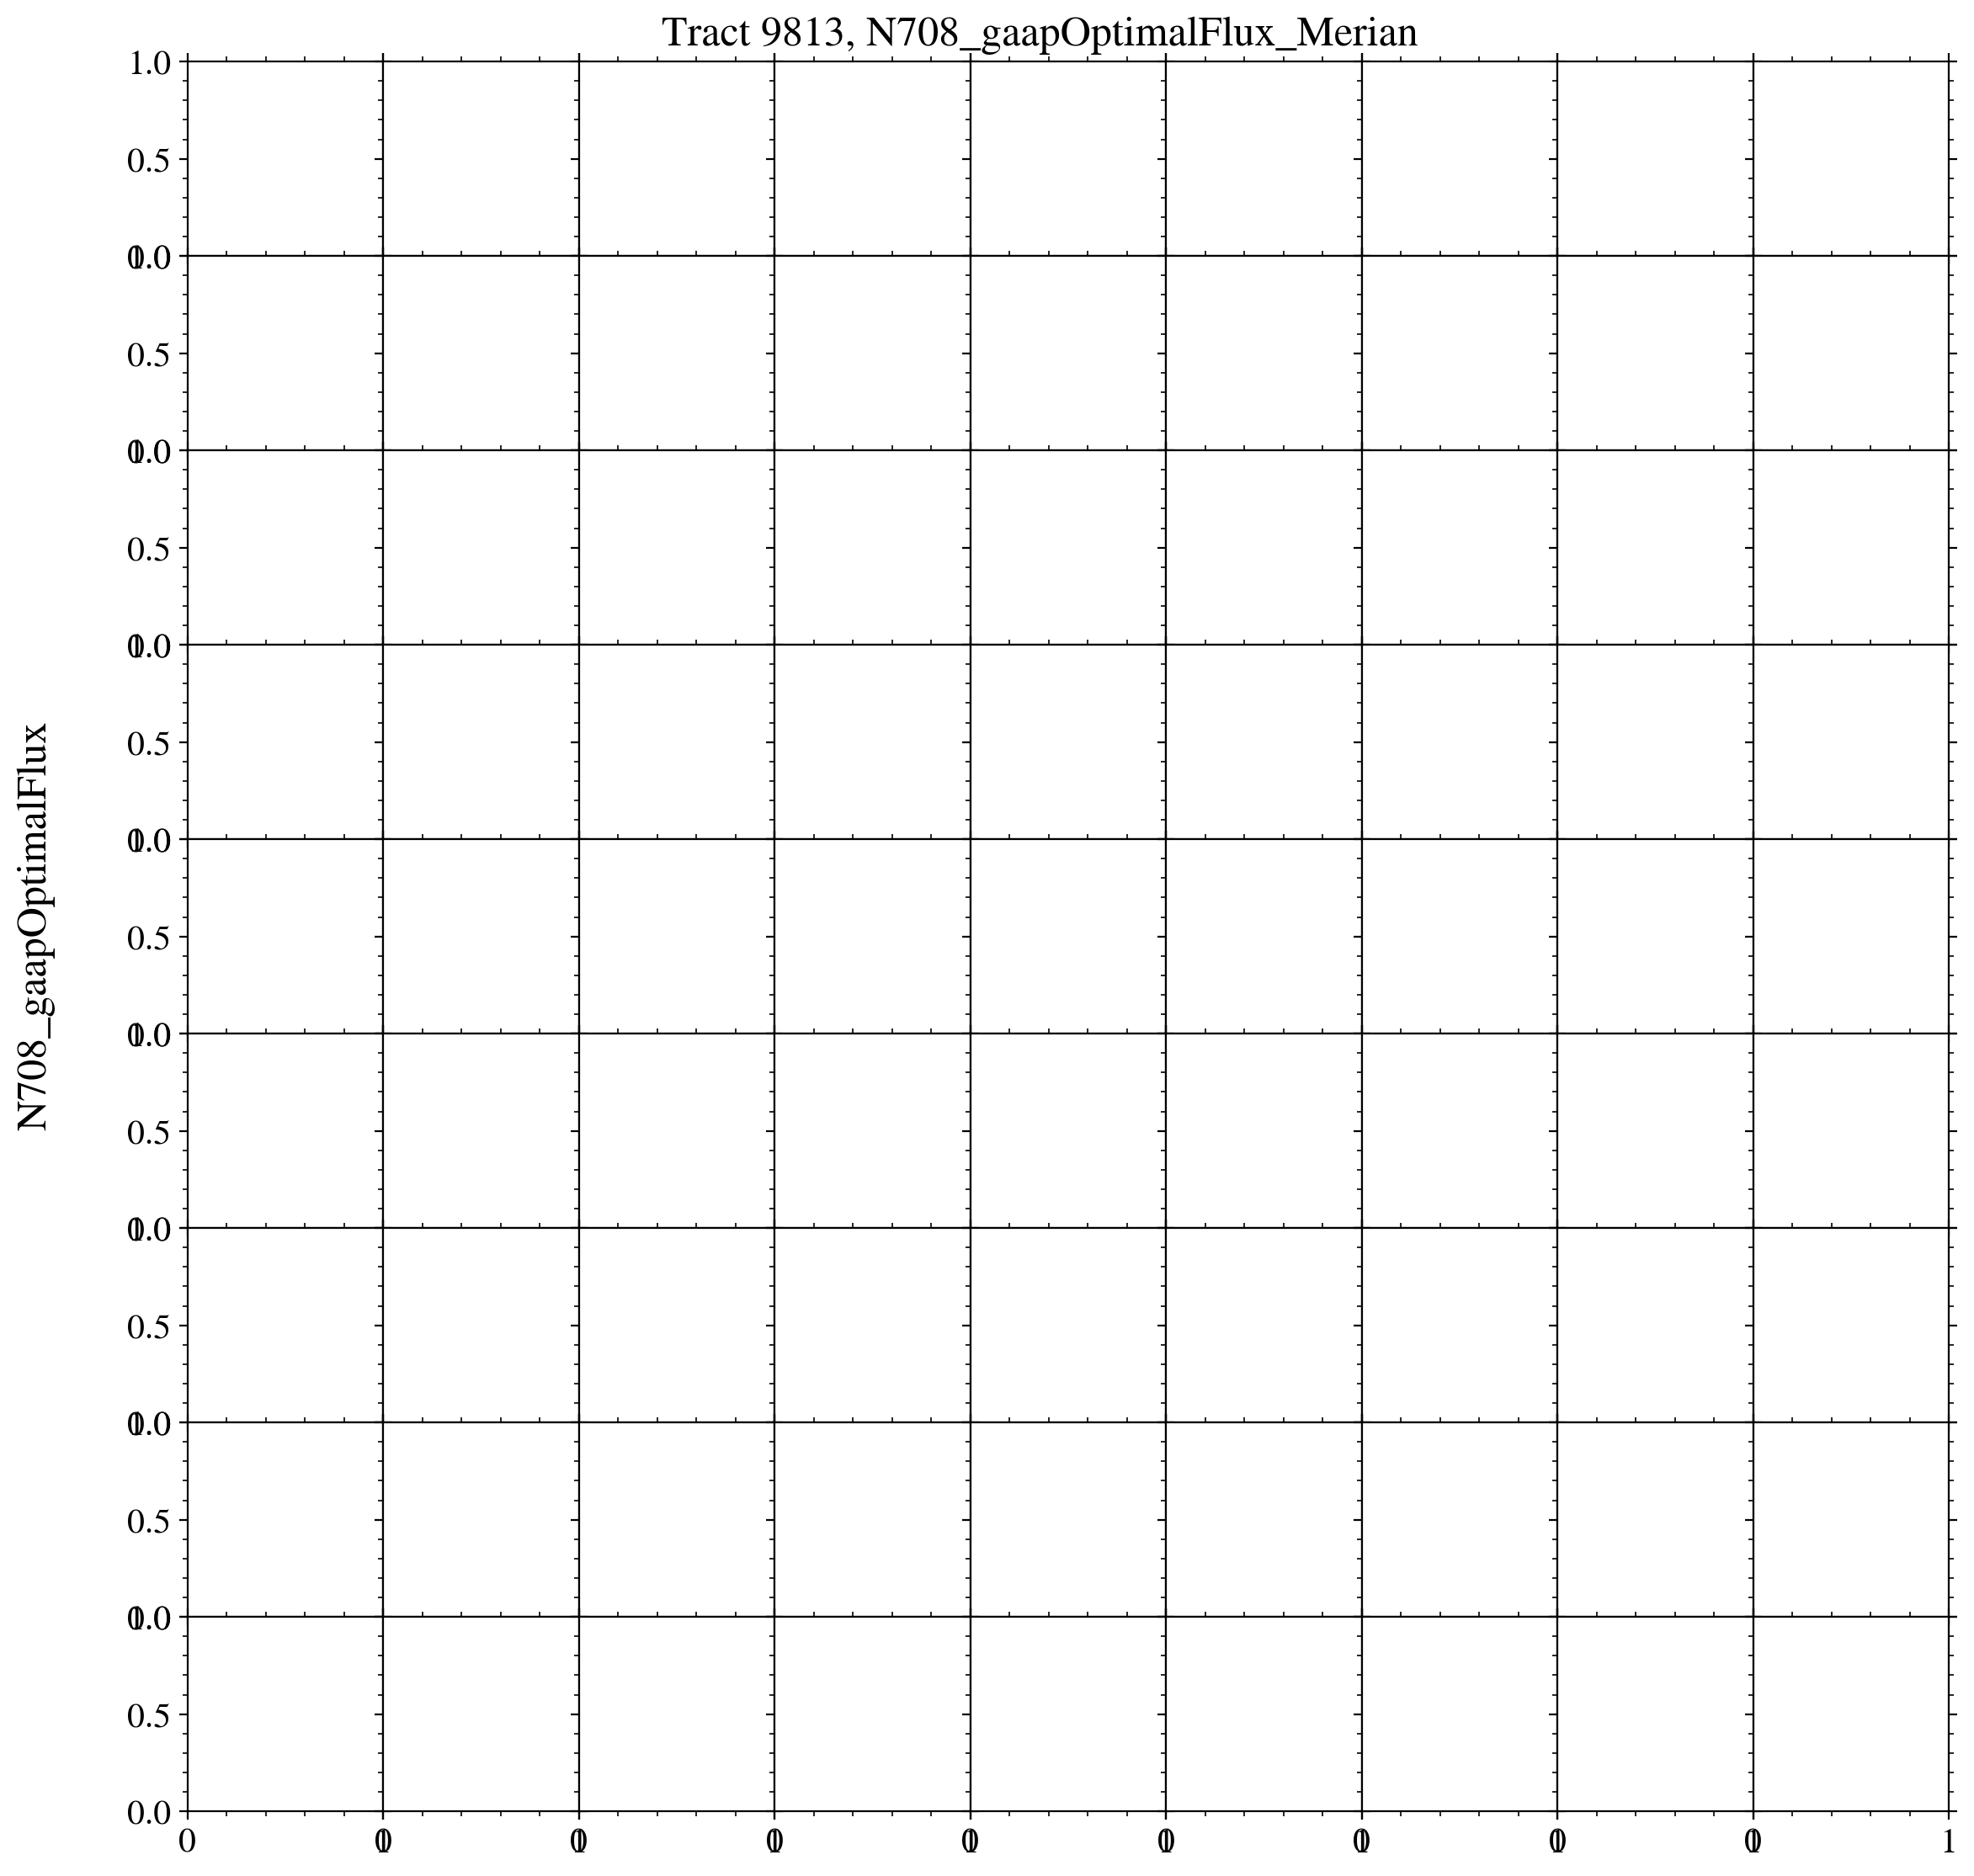

In [40]:

violin_fig, violin_axes = plt.subplots(9, 9, figsize=(9*1.5, 9*1.5), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)

for patch_id in patch_list:

        # load the skyobj catalog for this patch
        patch_cat = skyobj_cat[skyobj_cat['patch_Merian']==patch_id]
        patch_flux_raw = patch_cat[colname]
        mask, patch_flux = sigmaclip(patch_flux_raw)
        Neff = len(patch_flux)
        
        # calculate the median and std of the flux
        mid_flux = np.nanmedian(patch_flux)
        std_flux = np.sqrt(np.nanmean((patch_flux-mid_flux)**2))
        max_flux = np.nanmax(patch_flux)
        min_flux = np.nanmin(patch_flux)

        # plot the violin plot
        nrow = patch_id//9
        ncol = patch_id%9
        
        ax = violin_axes[8-nrow][ncol]
        plot_violin(ax,  patch_flux, 1)

        ax.set_ylim(-500,500)
        ax.set_xticks([])
        ax.text(0.05, 0.95, s='%d-(%d,%d)'%(patch_id, nrow, ncol), transform=ax.transAxes,va='top', ha='left', fontsize=15, color='tab:red')

_ = violin_fig.suptitle('Tract %d, %s'%(tract,colname), y=0.9)
 
_ = violin_fig.supylabel('N708_gaapOptimalFlux', x=0.05, y=0.5)